# Libraries

**Link for the repository: https://github.com/MargaridaNabais1/MargaridaNabais_Assignement1.git**

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas
from sklearn.decomposition import PCA

# Exercise 1: Diabetes Dataset (Regression)

**Importing the dataset, train test splitting and normalization:**
The first step is to import and prepare the dataset. The percentage for spliting tain and test data depends on the size of total samples, in this case as 442 samples is considered relatively small, the dataset should be split into a test size of approximately 20% to 30%.


In [2]:
from sklearn import datasets
#load dataset
diabetes= datasets.load_diabetes(as_frame=True)
X=diabetes.data
y=diabetes.target

print("X head:\n", X.head())       
print("y head:\n", y.head())

#train test spliting
test_size=0.2
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=42)

# Standardize features
scaler=StandardScaler()
Xtr= scaler.fit_transform(Xtr)
Xte= scaler.transform(Xte)

# Convert X and y to torch tensors
Xtr = torch.tensor(Xtr, dtype=torch.float32)

# Ensure ytr is a numpy array before converting
if hasattr(ytr, "to_numpy"):
    ytr_np = ytr.to_numpy().reshape(-1, 1)
else:
    ytr_np = np.array(ytr).reshape(-1, 1)

ytr = torch.tensor(ytr_np, dtype=torch.float32)

Xte = torch.tensor(Xte, dtype=torch.float32)

# Do the same for yte
if hasattr(yte, "to_numpy"):
    yte_np = yte.to_numpy().reshape(-1, 1)
else:
    yte_np = np.array(yte).reshape(-1, 1)

yte = torch.tensor(yte_np, dtype=torch.float32)

X head:
         age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  
0 -0.002592  0.019907 -0.017646  
1 -0.039493 -0.068332 -0.092204  
2 -0.002592  0.002861 -0.025930  
3  0.034309  0.022688 -0.009362  
4 -0.002592 -0.031988 -0.046641  
y head:
 0    151.0
1     75.0
2    141.0
3    206.0
4    135.0
Name: target, dtype: float64


**Clustering:**
In clustering, certain parameters must be tuned to optimize model performance, such as:  

**Number of clusters**:
The model was tested using from 2 to up 4 clusters. To evaluate the quality of each configuration it was taken into account the resulting fuzzy partition coefficient (FPC). In addition, plots were generated for each case to provide a visual perspective of the results  


**Fuzziness parameter (m)**: the fuzziness parameter controls cluster overlap, when m=1 we have hard partitioning, while m>1 introduces fuzziness, which allows samples to belong to multiple clusters with different degrees of membership. In this first phase the value of m was choosen to be 2 (simply because it is a default value) to focus primarily on the effect of the number of clusters.

Number of clusters: 2, Fuzzy partition coefficient (FPC): 0.8556


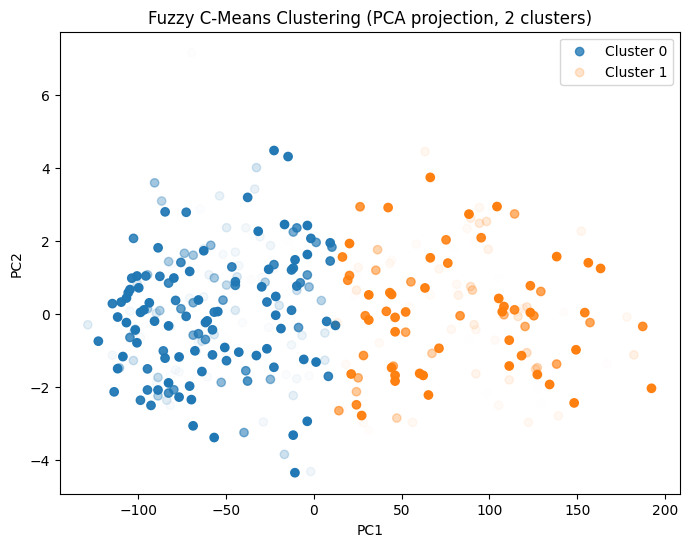

Number of clusters: 3, Fuzzy partition coefficient (FPC): 0.8077


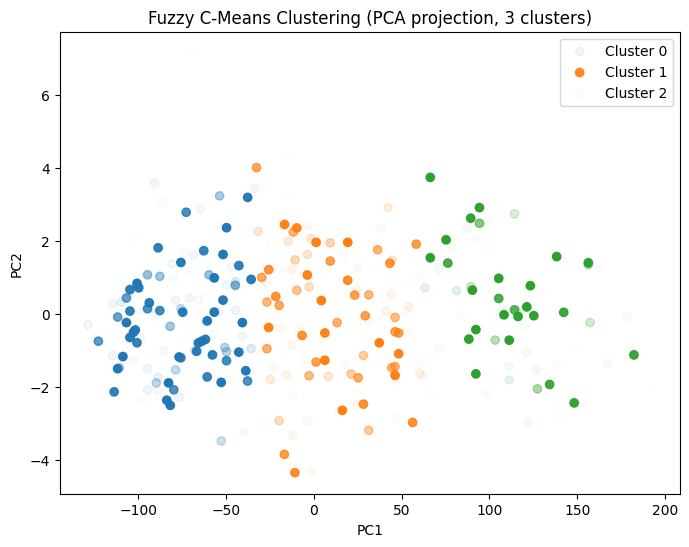

Number of clusters: 4, Fuzzy partition coefficient (FPC): 0.7803


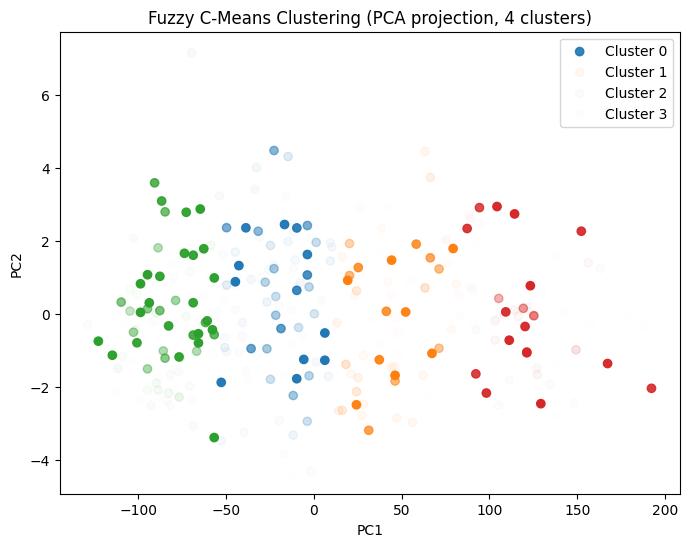

In [3]:
m = 2  # fuzziness coefficient

# Concatenate target for clustering (use numpy arrays)
Xexp = np.concatenate([Xtr.numpy(), ytr.numpy()], axis=1)

# Transpose data for skfuzzy (expects features x samples)
Xexp_T = Xexp.T

# Reduce data to 2D for plotting (use same data you clustered on)
Xexp_2d = PCA(n_components=2).fit_transform(Xexp)

# Try different numbers of clusters
for n_clusters in [2, 3, 4]:
    # Fuzzy C-means clustering
    centers, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        Xexp_T, n_clusters, m=m, error=0.005, maxiter=1000, init=None
    )

    # Compute sigma (spread) for each cluster
    sigmas = []
    for j in range(n_clusters):
        u_j = u[j, :] ** m
        var_j = np.average((Xexp - centers[j])**2, axis=0, weights=u_j)
        sigma_j = np.sqrt(var_j)
        sigmas.append(sigma_j)
    sigmas = np.array(sigmas)

    # Hard clustering from fuzzy membership
    cluster_labels = np.argmax(u, axis=0)

    print(f"Number of clusters: {n_clusters}, Fuzzy partition coefficient (FPC): {fpc:.4f}")

    # Plot PCA projection
    plt.figure(figsize=(8, 6))
    for j in range(n_clusters):
        plt.scatter(
            Xexp_2d[cluster_labels == j, 0],
            Xexp_2d[cluster_labels == j, 1],
            alpha=u[j, :],
            label=f'Cluster {j}'
        )
    plt.title(f"Fuzzy C-Means Clustering (PCA projection, {n_clusters} clusters)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.show()


        



To summarize, the resulting fpc values were:  
**2 clusters:** 0.8556  
**3 clusters:** 0.8077  
**4 clusters:** 0.7803  
It can be observed that the fpc value decreases as the number of clusters increases. This indicates that, for the case of this exercise the most apropriate number of clusters is 2 as it has a good fpc value and visually seems to group the samples well.  
In the next step, the effect of varying the fuzziness coefficient and the number of clusters is aalysed.


In [4]:
m_values = [1.5, 2.0, 2.5, 3.0]   # try different fuzziness coefficients
cluster_options = [2, 3, 4]       # number of clusters to test

# Make sure ytr is numpy before concatenating
if hasattr(ytr, "to_numpy"):  
    y_arr = ytr.to_numpy().reshape(-1, 1)
else:
    y_arr = np.array(ytr).reshape(-1, 1)

Xexp = np.concatenate([Xtr, y_arr], axis=1)
Xexp_T = Xexp.T

for m in m_values:
    print(f"\n=== Results for m = {m} ===")
    for n_clusters in cluster_options:
        centers, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
            Xexp_T, n_clusters, m=m, error=0.005, maxiter=1000, init=None
        )
        print(f"Clusters: {n_clusters}, FPC: {fpc:.4f}")


=== Results for m = 1.5 ===
Clusters: 2, FPC: 0.9397
Clusters: 3, FPC: 0.9217
Clusters: 4, FPC: 0.9153

=== Results for m = 2.0 ===
Clusters: 2, FPC: 0.8556
Clusters: 3, FPC: 0.8077
Clusters: 4, FPC: 0.7803

=== Results for m = 2.5 ===
Clusters: 2, FPC: 0.7764
Clusters: 3, FPC: 0.6899
Clusters: 4, FPC: 0.6401

=== Results for m = 3.0 ===
Clusters: 2, FPC: 0.7139
Clusters: 3, FPC: 0.5971
Clusters: 4, FPC: 0.5301


From the results we can conclude thatboth the fuzziness coefficient and the number of clusters greatly impact the model's performance. For example, when comparing the highest fpc scnerio (2 clusters and m=1,5) to the lowest fpc scenerio (4 clusters and m=3) we can see that fpc goes from 0.9397 to 0.5302. But choosing the parameters that lead to higher fpc is not always the best action as it does not necessarily mean thhat the model's performance is better, because of this it was defined the number of clusters as 2 and the fuzziness coefficient as 2. This aspect will be discussed more in dept in the classification exercise as the fpc values vary more.


In the next step we visualize the Gaussian-shaped membership function obtained from clustering considering 2 clusters and m=2. This plot allow us to analyse the degree of overlaping beetween clusters and see how the data points are separated, showcasing their borders.


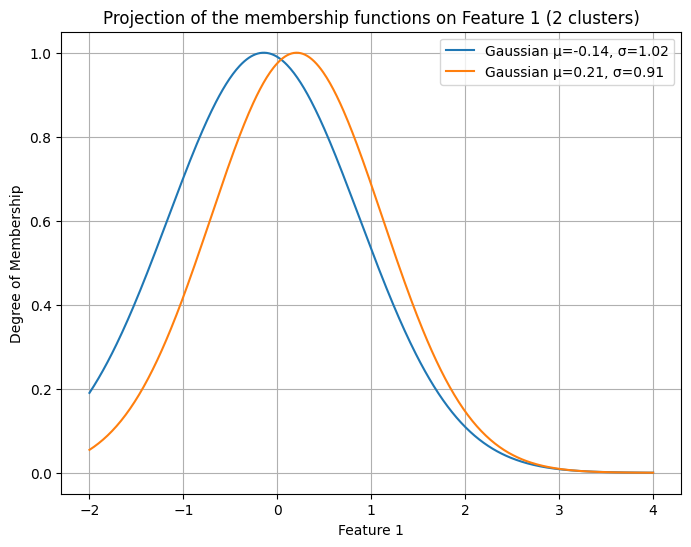

In [5]:
# Gaussian formula
def gaussian(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu) / sigma) ** 2)

# Run clustering again with 2 clusters and m=1.5 (best choice)
best_n_clusters = 2
centers, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    Xexp_T, best_n_clusters, m=2, error=0.005, maxiter=1000, init=None
)

# Compute sigmas for the 2 clusters
sigmas = []
for j in range(best_n_clusters):
    u_j = u[j, :] ** m
    var_j = np.average((Xexp - centers[j]) ** 2, axis=0, weights=u_j)
    sigma_j = np.sqrt(var_j)
    sigmas.append(sigma_j)
sigmas = np.array(sigmas)

# Gaussian curves
lin = np.linspace(-2, 4, 500)
plt.figure(figsize=(8, 6))

y_aux = []
for j in range(best_n_clusters):
    # Compute curves
    y_aux.append(gaussian(lin, centers[j, 0], sigmas[j, 0]))
    # Plot
    plt.plot(
        lin,
        y_aux[j],
        label=f"Gaussian μ={np.round(centers[j, 0], 2)}, σ={np.round(sigmas[j, 0], 2)}"
    )

plt.title("Projection of the membership functions on Feature 1 (2 clusters)")
plt.xlabel("Feature 1")
plt.ylabel("Degree of Membership")
plt.legend()
plt.grid(True)
plt.show()

From analysing the resulting plot for feature 1, we can see that there is some degree of overlap beetween the gaussian curves. This overlap suggests that the two clusters are not totaly separated when considering this feature alone (plots for other isolated features are very similar aswell), which mean separation becomes evident when considering conbination of various features simultaniously and not necessarily that the clustering was not effective

In [6]:
# ---------------------------
# Gaussian Membership Function
# ---------------------------
class GaussianMF(nn.Module):
    def __init__(self, centers, sigmas, agg_prob):
        super().__init__()
        self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
        self.sigmas = nn.Parameter(torch.tensor(sigmas, dtype=torch.float32))
        self.agg_prob=agg_prob

    def forward(self, x):
        # Expand for broadcasting
        # x: (batch, 1, n_dims), centers: (1, n_rules, n_dims), sigmas: (1, n_rules, n_dims)
        diff = abs((x.unsqueeze(1) - self.centers.unsqueeze(0))/self.sigmas.unsqueeze(0)) #(batch, n_rules, n_dims)

        # Aggregation
        if self.agg_prob:
            dist = torch.norm(diff, dim=-1)  # (batch, n_rules) # probablistic intersection
        else:
            dist = torch.max(diff, dim=-1).values  # (batch, n_rules) # min intersection (min instersection of normal funtion is the same as the max on dist)
        
        return torch.exp(-0.5 * dist ** 2)


# ---------------------------
# TSK Model
# ---------------------------
class TSK(nn.Module):
    def __init__(self, n_inputs, n_rules, centers, sigmas,agg_prob=False):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_rules = n_rules

        # Antecedents (Gaussian MFs)
        
        self.mfs=GaussianMF(centers, sigmas,agg_prob) 

        # Consequents (linear functions of inputs)
        # Each rule has coeffs for each input + bias
        self.consequents = nn.Parameter(
            torch.randn(n_inputs + 1,n_rules)
        )

    def forward(self, x):
        # x: (batch, n_inputs)
        batch_size = x.shape[0]
        
        # Compute membership values for each input feature
        # firing_strengths: (batch, n_rules)
        firing_strengths = self.mfs(x)
        
        # Normalize memberships
        # norm_fs: (batch, n_rules)
        norm_fs = firing_strengths / (firing_strengths.sum(dim=1, keepdim=True) + 1e-9)

        # Consequent output (linear model per rule)
        x_aug = torch.cat([x, torch.ones(batch_size, 1)], dim=1)  # add bias

        rule_outputs = torch.einsum("br,rk->bk", x_aug, self.consequents)  # (batch, rules)
        # Weighted sum
        output = torch.sum(norm_fs * rule_outputs, dim=1, keepdim=True)

        return output, norm_fs, rule_outputs

In [7]:
# ---------------------------
# Least Squares Solver for Consequents (TSK)
# ---------------------------
def train_ls(model, X, y):
    with torch.no_grad():
        _, norm_fs, _ = model(X)

        # Design matrix for LS: combine normalized firing strengths with input
        X_aug = torch.cat([X, torch.ones(X.shape[0], 1)], dim=1)
        
        Phi = torch.einsum("br,bi->bri", X_aug, norm_fs).reshape(X.shape[0], -1)
        
        # Solve LS: consequents = (Phi^T Phi)^-1 Phi^T y
        
        theta= torch.linalg.lstsq(Phi, y).solution
    
        
        model.consequents.data = theta.reshape(model.consequents.shape)

In [8]:
#build model
Xtr = torch.tensor(Xtr, dtype=torch.float32)
ytr = torch.tensor(ytr, dtype=torch.float32).view(-1, 1)
Xte = torch.tensor(Xte, dtype=torch.float32)
yte = torch.tensor(yte, dtype=torch.float32).view(-1, 1)

best_n_clusters = 2  

model = TSK(
    n_inputs=Xtr.shape[1],
    n_rules=best_n_clusters,  
    centers=centers[:, :-1],
    sigmas=sigmas[:, :-1],
    agg_prob=False
)

C:\Users\user\AppData\Local\Temp\ipykernel_968\2812766019.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Xtr = torch.tensor(Xtr, dtype=torch.float32)
C:\Users\user\AppData\Local\Temp\ipykernel_968\2812766019.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ytr = torch.tensor(ytr, dtype=torch.float32).view(-1, 1)
C:\Users\user\AppData\Local\Temp\ipykernel_968\2812766019.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Xte = torch.tensor(Xte, dtype=torch.float32)
C:\Users\user\AppData\Local\Temp\ipykernel_968\2812766019.py:5: Use

In [9]:
# Training with LS:
train_ls(model, Xtr, ytr.reshape(-1,1))

In [10]:
y_pred, _, _=model(Xte)
#performance metric for regression
print(f'MSE:{mean_squared_error(yte.detach().numpy(),y_pred.detach().numpy())}') #regression


MSE:2543.396240234375


**MSE:**  
The mean squared error measures the average squared difference between the predicted and actual target values, measuring the accuracy of the model predictive power. In this case, the resulting MSE suggests a moderate level of error. One reason for this could be the low number of rules in the model, which corresponds to the number of clusters, while we previously considered 2 clusters as optimal based on the fpc, this low number may not fully translate the complexity of the data and leading to higher MSE.
It is also important to mention that there is a potential trade-off beetween  FPC and MSE, increasing the number of clusters might reduce MSE as it was mentioned but may also reduce FPC.

# Exercise 2: Pima Indians Diabetes Dataset (Classification)

Loading of dataset:
The data is loaded, split and standardized in exactly the same way and with the same logic as in the previous exercise 

In [11]:
from sklearn.datasets import fetch_openml

diabetes = fetch_openml("diabetes", version=1, as_frame=True)
X=diabetes.data
y=diabetes.target

#Making sure the data is being correctly loaded:
print("X head:\n", X.head())       
print("y head:\n", y.head())

#train test spliting
test_size=0.2
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=42)

# Standardize features
scaler=StandardScaler()
Xtr= scaler.fit_transform(Xtr)
Xte= scaler.transform(Xte)

import numpy as np

# Convert categorical target to numeric 0/1
ytr_num = ytr.map({'tested_negative': 0, 'tested_positive': 1}).to_numpy().reshape(-1, 1)

# Concatenate features + numeric target
Xexp = np.concatenate([Xtr, ytr_num], axis=1)

# Ensure float type
Xexp = Xexp.astype(np.float32)

# Transpose for skfuzzy (expects features x samples)
Xexp_T = Xexp.T

X head:
    preg  plas  pres  skin  insu  mass   pedi  age
0     6   148    72    35     0  33.6  0.627   50
1     1    85    66    29     0  26.6  0.351   31
2     8   183    64     0     0  23.3  0.672   32
3     1    89    66    23    94  28.1  0.167   21
4     0   137    40    35   168  43.1  2.288   33
y head:
 0    tested_positive
1    tested_negative
2    tested_positive
3    tested_negative
4    tested_positive
Name: class, dtype: category
Categories (2, object): ['tested_negative', 'tested_positive']


**Clustering:**
Just like in the previous exercise, it is fundamental to identify the optimal values for the number of clusters and fuzziness coefficient, so once again it was calculated the fpc for different values of clusters and m.

In [12]:
from sklearn.preprocessing import StandardScaler

# Number of clusters
n_clusters = 3
m = 2

# Convert target to numerical values
ytr_num = ytr.map({'tested_negative': 0, 'tested_positive': 1}).to_numpy()

# Optional: standardize the target
scaler_y = StandardScaler()
ytr_scaled = scaler_y.fit_transform(ytr_num.reshape(-1, 1))

# Concatenate standardized features with standardized target
Xexp = np.concatenate([Xtr, ytr_scaled], axis=1)

# Transpose data for skfuzzy (expects features x samples)
Xexp_T = Xexp.T

# Fuzzy C-means clustering
centers, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    Xexp_T, n_clusters, m=m, error=0.005, maxiter=1000, init=None
)
centers.shape


(3, 9)

In [13]:
# Compute sigma (spread) for each cluster
sigmas = []
for j in range(n_clusters):
    # membership weights for cluster j, raised to m
    u_j = u[j, :] ** m
    # weighted variance for each feature
    var_j = np.average((Xexp - centers[j])**2, axis=0, weights=u_j)
    sigma_j = np.sqrt(var_j)
    sigmas.append(sigma_j)
sigmas=np.array(sigmas)

In [14]:
m_values = [1.1, 1.5, 2, 2.5]
cluster_options = [2, 3, 4]

for m in m_values:
    print(f"\n=== Results for m = {m} ===")
    for n_clusters in cluster_options:
        centers, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
            Xexp_T, n_clusters, m=m, error=0.005, maxiter=1000, init=None
        )
        print(f"Clusters: {n_clusters}, FPC: {fpc:.4f}")


=== Results for m = 1.1 ===
Clusters: 2, FPC: 0.9292
Clusters: 3, FPC: 0.9228
Clusters: 4, FPC: 0.8981

=== Results for m = 1.5 ===
Clusters: 2, FPC: 0.6777
Clusters: 3, FPC: 0.5484
Clusters: 4, FPC: 0.4625

=== Results for m = 2 ===
Clusters: 2, FPC: 0.5270
Clusters: 3, FPC: 0.3542
Clusters: 4, FPC: 0.2655

=== Results for m = 2.5 ===
Clusters: 2, FPC: 0.5000
Clusters: 3, FPC: 0.3333
Clusters: 4, FPC: 0.2500


As we observed, higher fpc values tend to occur when using a lower number of clusters or smaller fuziness coefficients, however as previously noted, a higher FPC does not necessarily leads to better predictive performance. This is because of the trade-off mentioned: very low and unreasonable values of m draw the algorithm closer to k-means, emphasizing hard clustering and being further away from fuzzy membership.  
In this exercise the values of FPC vary much more than previously, but considering the fact just mentioned it is not worth it to consider the scenarios for when m<1 which is very low even if they present high FPC values. Since m values normally range from 1.5 to 2.5, with being 2 the default and noting that for 2 clusters and m=2 we obtain an FPC of 0.5271, these parameter values where chosen.

Fuzzy partition coefficient (FPC) for 2 clusters: 0.5271


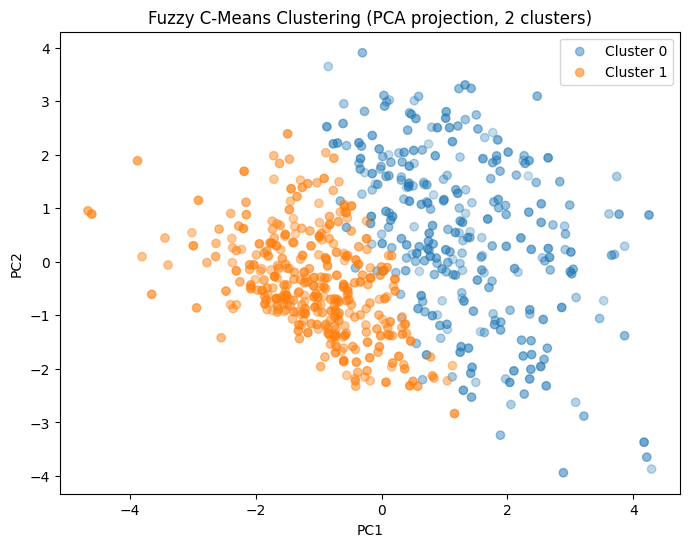

In [15]:
from sklearn.decomposition import PCA

# Force n_clusters = 2 for plotting
n_clusters = 2
m = 2  # you can choose your desired fuzziness

# Run FCM specifically for 2 clusters
centers, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    Xexp_T, n_clusters, m=m, error=0.005, maxiter=1000, init=None
)

# Reduce data to 2D for plotting
Xexp_2d = PCA(n_components=2).fit_transform(Xexp)

# Hard clustering from fuzzy membership
cluster_labels = np.argmax(u, axis=0)
print(f"Fuzzy partition coefficient (FPC) for {n_clusters} clusters: {fpc:.4f}")

# Plot two principal components with fuzzy membership
plt.figure(figsize=(8,6))
for j in range(n_clusters):
    plt.scatter(
        Xexp_2d[cluster_labels == j, 0],    # PC1
        Xexp_2d[cluster_labels == j, 1],    # PC2
        alpha=u[j, :],                      # transparency ~ membership
        label=f'Cluster {j}'
    )

plt.title(f"Fuzzy C-Means Clustering (PCA projection, {n_clusters} clusters)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

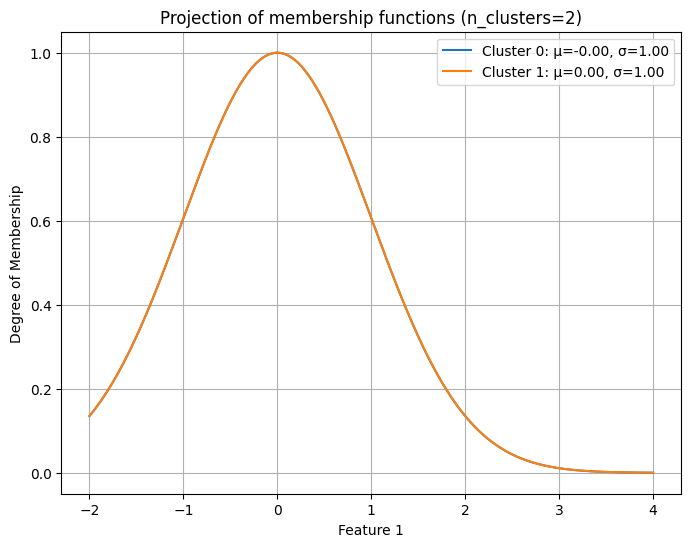

In [16]:
# Gaussian formula
def gaussian(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu)/sigma)**2)

lin = np.linspace(-2, 4, 500)

# Loop over number of clusters
for n_clusters in [2]:
    # Fuzzy C-means clustering
    centers, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        Xexp_T, n_clusters, m=2, error=0.005, maxiter=1000, init=None
    )
    
    # Compute sigmas for **this specific clustering**
    sigmas = []
    for j in range(n_clusters):
        u_j = u[j, :] ** 2  
        var_j = np.average((Xexp - centers[j])**2, axis=0, weights=u_j)
        sigma_j = np.sqrt(var_j)
        sigmas.append(sigma_j)
    sigmas = np.array(sigmas)
    
    # Plot Gaussian curves for feature 1
    plt.figure(figsize=(8,6))
    for j in range(n_clusters):
        plt.plot(lin, gaussian(lin, centers[j,0], sigmas[j, 0]),
                 label=f"Cluster {j}: μ={centers[j,0]:.2f}, σ={sigmas[j,0]:.2f}")
    
    plt.title(f"Projection of membership functions (n_clusters={n_clusters})")
    plt.xlabel("Feature 1")
    plt.ylabel("Degree of Membership")
    plt.legend()
    plt.grid(True)
    plt.show()

By observing the plot we can draw the same conclusion as in the precious exercise: separation between clusters is clearer when considering a combination of features in contrast to isolated ones 

In [17]:
# ---------------------------
# Gaussian Membership Function
# ---------------------------
class GaussianMF(nn.Module):
    def __init__(self, centers, sigmas, agg_prob):
        super().__init__()
        self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
        self.sigmas = nn.Parameter(torch.tensor(sigmas, dtype=torch.float32))
        self.agg_prob=agg_prob

    def forward(self, x):
        # Expand for broadcasting
        # x: (batch, 1, n_dims), centers: (1, n_rules, n_dims), sigmas: (1, n_rules, n_dims)
        diff = abs((x.unsqueeze(1) - self.centers.unsqueeze(0))/self.sigmas.unsqueeze(0)) #(batch, n_rules, n_dims)

        # Aggregation
        if self.agg_prob:
            dist = torch.norm(diff, dim=-1)  # (batch, n_rules) # probablistic intersection
        else:
            dist = torch.max(diff, dim=-1).values  # (batch, n_rules) # min intersection (min instersection of normal funtion is the same as the max on dist)
        
        return torch.exp(-0.5 * dist ** 2)


# ---------------------------
# TSK Model
# ---------------------------
class TSK(nn.Module):
    def __init__(self, n_inputs, n_rules, centers, sigmas,agg_prob=False):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_rules = n_rules

        # Antecedents (Gaussian MFs)
        
        self.mfs=GaussianMF(centers, sigmas,agg_prob) 

        # Consequents (linear functions of inputs)
        # Each rule has coeffs for each input + bias
        self.consequents = nn.Parameter(
            torch.randn(n_inputs + 1,n_rules)
        )

    def forward(self, x):
        # x: (batch, n_inputs)
        batch_size = x.shape[0]
        
        # Compute membership values for each input feature
        # firing_strengths: (batch, n_rules)
        firing_strengths = self.mfs(x)
        
        # Normalize memberships
        # norm_fs: (batch, n_rules)
        norm_fs = firing_strengths / (firing_strengths.sum(dim=1, keepdim=True) + 1e-9)

        # Consequent output (linear model per rule)
        x_aug = torch.cat([x, torch.ones(batch_size, 1)], dim=1)  # add bias

        rule_outputs = torch.einsum("br,rk->bk", x_aug, self.consequents)  # (batch, rules)
        # Weighted sum
        output = torch.sum(norm_fs * rule_outputs, dim=1, keepdim=True)

        return output, norm_fs, rule_outputs

In [18]:
# ---------------------------
# Least Squares Solver for Consequents (TSK)
# ---------------------------
def train_ls(model, X, y):
    with torch.no_grad():
        _, norm_fs, _ = model(X)

        # Design matrix for LS: combine normalized firing strengths with input
        X_aug = torch.cat([X, torch.ones(X.shape[0], 1)], dim=1)
        
        Phi = torch.einsum("br,bi->bri", X_aug, norm_fs).reshape(X.shape[0], -1)
        
        # Solve LS: consequents = (Phi^T Phi)^-1 Phi^T y
        
        theta= torch.linalg.lstsq(Phi, y).solution
    
        
        model.consequents.data = theta.reshape(model.consequents.shape)

In [19]:
centers_features = centers[:, :Xtr.shape[1]]  
sigmas_features  = sigmas[:, :Xtr.shape[1]]

print(centers_features.shape)  
print(sigmas_features.shape)   

model = TSK(
    n_inputs=Xtr.shape[1], 
    n_rules=n_clusters, 
    centers=centers_features,
    sigmas=sigmas_features,
    agg_prob=False
)

(2, 8)
(2, 8)


In [20]:
Xtr_t = torch.tensor(Xtr, dtype=torch.float32).clone().detach()
ytr_num = ytr.map({'tested_negative': 0, 'tested_positive': 1}).values
ytr_t = torch.tensor(ytr_num.reshape(-1,1), dtype=torch.float32).clone().detach()
# Training with LS:
train_ls(model, Xtr_t, ytr_t)

In [21]:
# Convert test features to PyTorch tensor
Xte_t = torch.tensor(Xte, dtype=torch.float32)

# Convert test labels to numeric and then to PyTorch tensor
yte_num = yte.map({'tested_negative': 0, 'tested_positive': 1}).values
yte_t = torch.tensor(yte_num.reshape(-1,1), dtype=torch.float32)

# Make predictions
y_pred, _, _ = model(Xte_t)

# Compute classification accuracy
acc = accuracy_score(yte_t.detach().numpy(), (y_pred.detach().numpy() > 0.5))
print(f'ACC: {acc}')

ACC: 0.7662337662337663


In the end, the model achieved an accuracy of approximately 0.78, which can be cosidered a reasonable result. As discussed previously, optimizing accuracy requires balancing the trade-off  between FPC and predictive performance. As it was mentioned it is not worth it to choose a scenario that has a high value of fpc if it stems from unreasonably low values of m. For instance, when a model defined with 2 clusters and a very low value of m (close to 1) which had a high FPC value was tested, the accuracy decreased. Similarly, increasing the number of clusters also led to a decrease in inaccuracy.  
In conclusion, it is not advised to select parameter values based only in FPC especially if they result from unrealistic values of fuzziness coefficients 